# Visualize Wave of History Matching
Plotting scripts to visualize the output from a given wave of history matching included the trained GP emulator, the proposed next wave _(NROY)_ space and the implausibility function. 

In [5]:
import config 
import xarray as xr
import os
import joblib 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from history_matching.emulator import GPEmulator
from history_matching.samples import SampleSpace

DATADIR = '/Users/robcking/PhD/history_matching_data/new/50_sample_exp' ## DIRECTORY CONTAINING OUTPUT FOR A GIVEN EXPERIMENT
ITERATION_NUMBER = 0 ## ITERATION OF HISTORY MATCHING TO GENERATE PLOTS FOR 



## Load in correct data

In [6]:
space:SampleSpace = joblib.load(os.path.join(DATADIR,f'{ITERATION_NUMBER}.space'))
space0:SampleSpace = joblib.load(os.path.join(DATADIR,f'0.space')) ## Initial iteration 0 range of plausible parameters

samples =pd.concat([ pd.read_csv(os.path.join(DATADIR,f'{i}_samples.csv'),index_col='run_id') for i in range(ITERATION_NUMBER+1)])


In [7]:
def get_data(base_dir,iter_num=0):
    X = np.concatenate([
      np.load(os.path.join(base_dir,f'wave_{i}','analysis','X.npy'))  
    for i in range(iter_num+1)])
    y = np.concatenate([
      np.load(os.path.join(base_dir,f'wave_{i}','analysis','y.npy'))  
    for i in range(iter_num+1)])
    y_err = np.concatenate([
      np.load(os.path.join(base_dir,f'wave_{i}','analysis','y_err.npy'))  
    for i in range(iter_num+1)])
    return X,y,y_err

X,y,y_err = get_data(DATADIR,ITERATION_NUMBER)

badys = np.isnan(y).any(axis=1)
X =X[~badys]
y = y[~badys]
y_err = y_err[~badys]

em = GPEmulator(n_features=2,random_state=42)
em.fit(X,y,y_err)

### Emulator Prediction
Predict over the entire initial range of plausible parameters and extract the predicted QBO period + amplitude

In [8]:
pred,prederr = em.predict_over_space(space0,return_std=True) 
period,perioderr,amp,amperr = pred[0],prederr[0],pred[1],prederr[1]

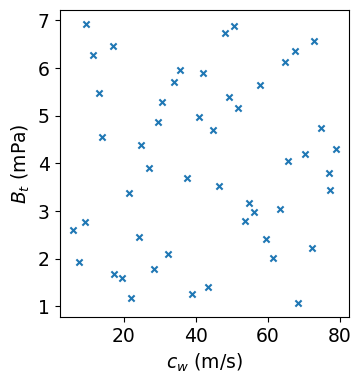

In [14]:
fig1,ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

fig1.tight_layout(pad=1.5)
##PLOT 1

# CSPERIOD = period.plot.contour(ax=axperiod,levels=25,x='cwtropics',y='Bt_eq')
samples.plot.scatter(ax=ax,x='cwtropics',y='Bt_eq',marker='x')
# # axperiod.clabel(CSPERIOD,CSPERIOD.levels,inline=True,fontsize=10)
# axperiod.set_ylabel("$B_{t}$ (mPa)")
# axperiod.set_xlabel("$c_{w}$ (m/s)")
# axperiod.set_title("QBO Period (months)")
# axperiod.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x*1000)))

# ##PLOT 2
# CSAMPLITUDE= amp.plot.contour(ax=axamp,levels=25,x='cwtropics',y='Bt_eq')
# samples.plot.scatter(ax=axamp,x='cwtropics',y='Bt_eq',marker='x')
# axamp.clabel(CSAMPLITUDE,CSAMPLITUDE.levels,inline=True,fontsize=10)
ax.set_ylabel("$B_{t}$ (mPa)")
ax.set_xlabel("$c_{w}$ (m/s)")
# axamp.set_title("QBO Amplitude (m/s)")
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x*1000)))
fig1.savefig(f'figures/emulator_50_I{ITERATION_NUMBER}_SAMPLES.png',dpi=250)


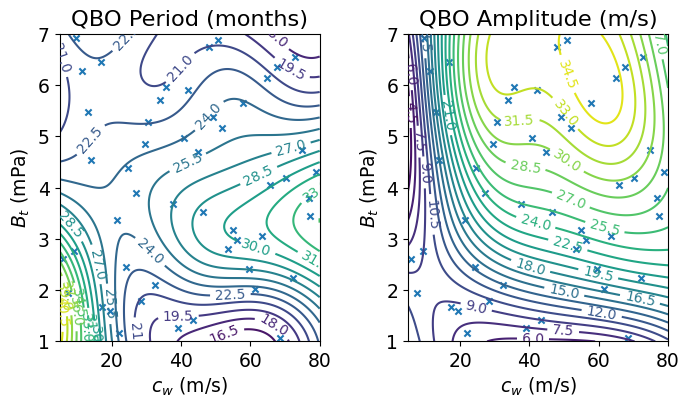

In [10]:
fig1,(axperiod,axamp) = plt.subplots(nrows=1,ncols=2,figsize=(7.25,4))

fig1.tight_layout(pad=1.5)
##PLOT 1

CSPERIOD = period.plot.contour(ax=axperiod,levels=25,x='cwtropics',y='Bt_eq')
samples.plot.scatter(ax=axperiod,x='cwtropics',y='Bt_eq',marker='x')
axperiod.clabel(CSPERIOD,CSPERIOD.levels,inline=True,fontsize=10)
axperiod.set_ylabel("$B_{t}$ (mPa)")
axperiod.set_xlabel("$c_{w}$ (m/s)")
axperiod.set_title("QBO Period (months)")
axperiod.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x*1000)))

##PLOT 2
CSAMPLITUDE= amp.plot.contour(ax=axamp,levels=25,x='cwtropics',y='Bt_eq')
samples.plot.scatter(ax=axamp,x='cwtropics',y='Bt_eq',marker='x')
axamp.clabel(CSAMPLITUDE,CSAMPLITUDE.levels,inline=True,fontsize=10)
axamp.set_ylabel("$B_{t}$ (mPa)")
axamp.set_xlabel("$c_{w}$ (m/s)")
axamp.set_title("QBO Amplitude (m/s)")
axamp.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x*1000)))
fig1.savefig(f'figures/emulator_50_I{ITERATION_NUMBER}.png',dpi=250)


### Implausibility Plot 

First we need to get the reference QBO period and amplitudes (alongside associated errors)

In [21]:
from qbo_utils.qbo_ref import fetch_qbo_file,get_reference_qbo
period_ref,period_ref_err,amplitude_ref,amplitude_ref_err = get_reference_qbo(fetch_qbo_file(local_path='./qbo.dat'))

In [22]:
from history_matching.emulator import implausibility2
imp_map = implausibility2(
    pred,prederr,
    np.array([period_ref,amplitude_ref]),
    np.array([period_ref_err,amplitude_ref_err]),
)

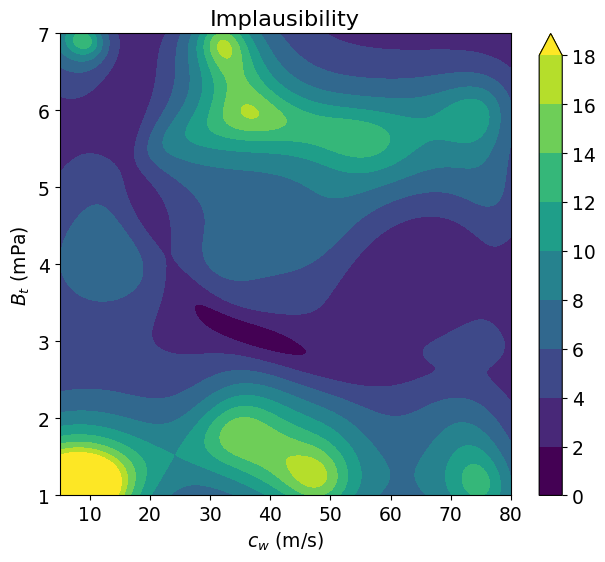

In [23]:
fig2,aximp = plt.subplots(figsize=(7.28,6))
## PLOT 3
np.sqrt(imp_map).plot.contourf(ax=aximp,x='cwtropics',y='Bt_eq',levels=np.arange(0,20,2))
aximp.set_ylabel("$B_t$ (mPa)")
aximp.set_xlabel("$c_w$ (m/s)")
aximp.set_title("Implausibility")
aximp.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x*1000)))

fig2.savefig('figures/implausibility_50.png',dpi=200,bbox_inches='tight')


### Cross Section Plot
Plot a cross section showing the mean value of emulator and 95% confidence intervals. A fixed value for either $B_t$ or $c_w$ is required to be set beforehand.

#### $B_t$ fixed plot

In [24]:
BT_FIXED = 0.0025
cw = space0.to_xarray().cwtropics.to_numpy()
X = np.stack([cw,np.ones(len(cw))*BT_FIXED]).T
pred_btfixed,pred_btfixed_std = em.predict(X,return_std=True)
pred_period_btw = pred_btfixed[:,0]
pred_period_btw_std = pred_btfixed_std[:,0]*1.96
pred_amplitude_bt = pred_btfixed[:,1]
pred_amplitude_bt_std = pred_btfixed_std[:,1]*1.96


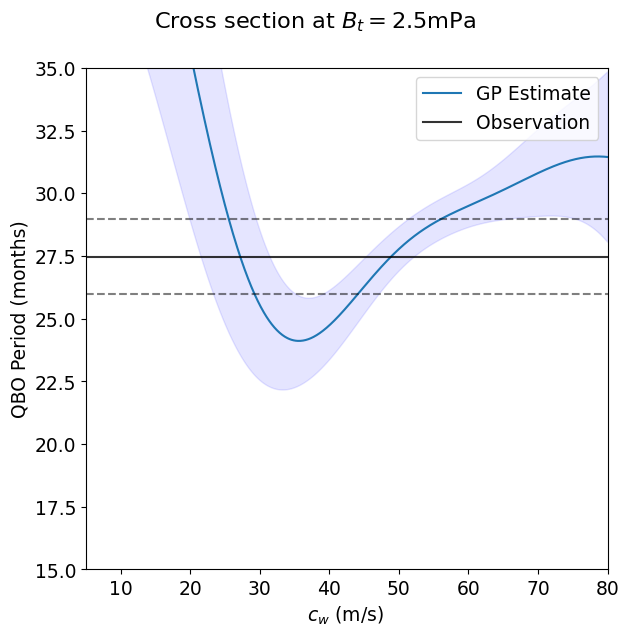

In [25]:
fig,ax = plt.subplots(figsize=(6.5,6.5))
ax.plot(cw,pred_period_btw,label='GP Estimate')
ax.fill_between(cw, (pred_period_btw-pred_period_btw_std), (pred_period_btw+pred_period_btw_std), color='b', alpha=.1)
ax.set_xlim([5,80])
ax.axhline(period_ref -period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.axhline(period_ref,linestyle='-',color='black',alpha=0.8,label='Observation')
ax.axhline(period_ref+period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.set_xlabel("$c_w$ (m/s) ")
ax.set_ylabel('QBO Period (months)')
ax.legend()

ax.set_ylim([15,35])


fig.suptitle('Cross section at $B_t ='+str(BT_FIXED*1000)+'$mPa')
fig.tight_layout()
fig.savefig(f'figures/wave_{ITERATION_NUMBER}_period_btconst.png',dpi=300)

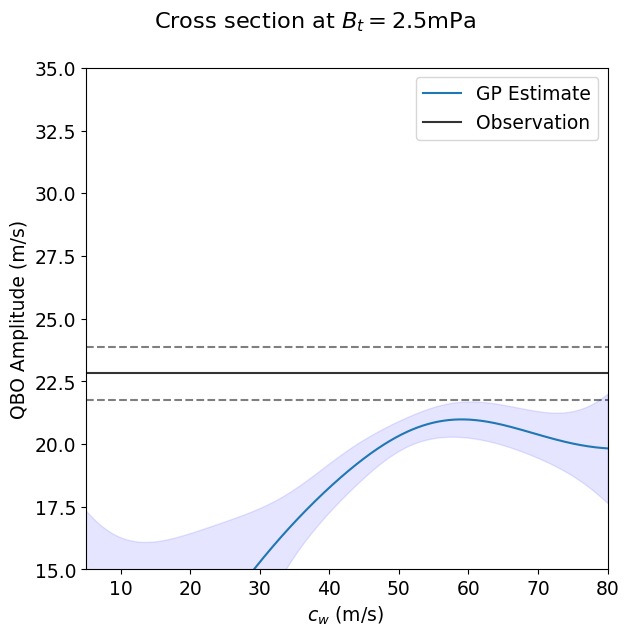

In [26]:
fig,ax = plt.subplots(figsize=(6.5,6.5))
ax.plot(cw,pred_amplitude_bt,label='GP Estimate')
ax.fill_between(cw, (pred_amplitude_bt-pred_amplitude_bt_std), (pred_amplitude_bt+pred_amplitude_bt_std), color='b', alpha=.1)
ax.set_xlim([5,80])
ax.axhline(amplitude_ref -amplitude_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.axhline(amplitude_ref,linestyle='-',color='black',alpha=0.8,label='Observation')
ax.axhline(amplitude_ref+amplitude_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.set_xlabel("$c_w$ (m/s) ")
ax.set_ylabel('QBO Amplitude (m/s)')
ax.legend()

ax.set_ylim([15,35])


fig.suptitle('Cross section at $B_t ='+str(BT_FIXED*1000)+'$mPa')
fig.tight_layout()
fig.savefig(f'figures/wave_{ITERATION_NUMBER}_amplitude_btconst.png',dpi=300)


#### $c_w$ fixed plot

In [27]:
CW_FIXED = 50
Bt = space0.to_xarray().Bt_eq.to_numpy()
X = np.stack([np.ones(len(Bt))*CW_FIXED,Bt]).T
pred_cwfixed,pred_cwfixed_std = em.predict(X,return_std=True)
pred_period_cw = pred_cwfixed[:,0]
pred_period_cw_std = pred_cwfixed_std[:,0]*1.96
pred_amp_cw = pred_cwfixed[:,1]
pred_amp_cw_std = pred_cwfixed_std[:,1]*1.96


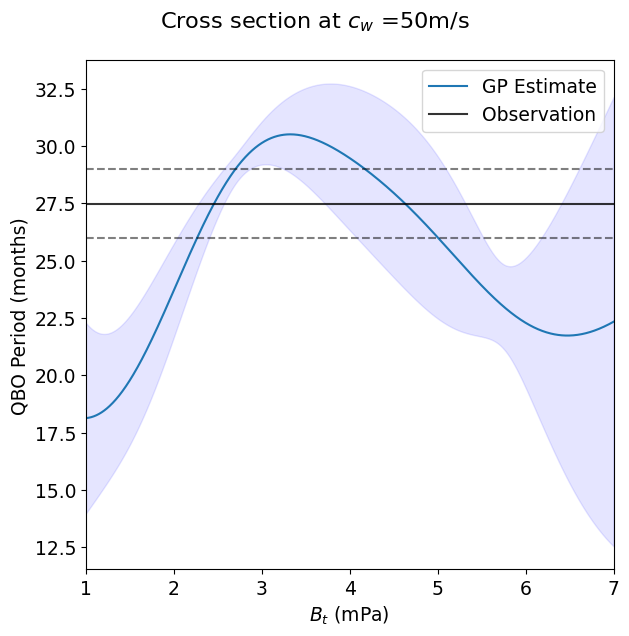

In [28]:
fig,ax = plt.subplots(figsize=(6.5,6.5))
ax.plot(Bt*1000,pred_period_cw,label='GP Estimate')
ax.fill_between(Bt*1000, (pred_period_cw-pred_period_cw_std), (pred_period_cw+pred_period_cw_std), color='b', alpha=.1)
ax.set_xlim([1,7])
ax.axhline(period_ref-period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.axhline(period_ref,linestyle='-',color='black',alpha=0.8,label='Observation')
ax.axhline(period_ref+period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.set_xlabel('$B_{t}$ (mPa)')
ax.set_ylabel('QBO Period (months)')
ax.legend()
# ax2.plot(Bt,imp)
# ax2.fill_between(Bt,0,3,color='g',alpha=0.1,label='Satisfied 3 sigma rule')
# ax2.set_xlim([0.001,0.007])
# ax2.set_ylim([0,20])
# ax2.legend()
# ax2.set_ylabel("Implausibility")
fig.suptitle('Cross section at $c_w$ ='+str(CW_FIXED)+'m/s')
fig.tight_layout()
fig.savefig(f'figures/wave_{ITERATION_NUMBER}_period_cwconst.png',dpi=300)


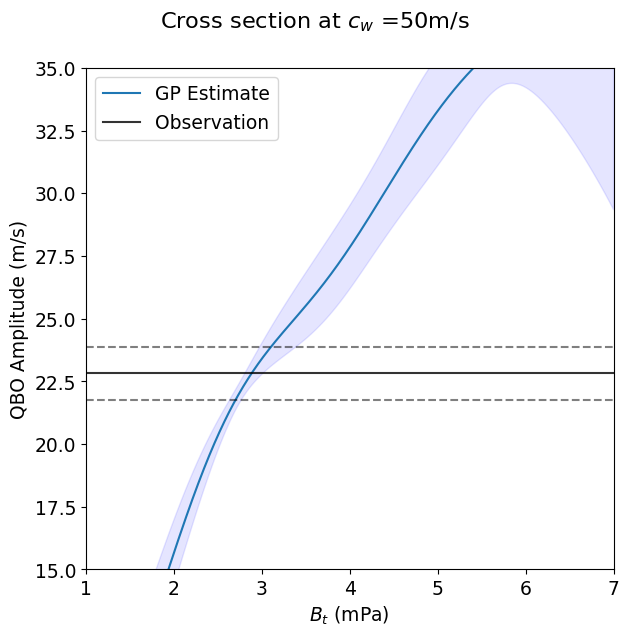

In [29]:
fig,ax = plt.subplots(figsize=(6.5,6.5))
ax.plot(Bt*1000,pred_amp_cw,label='GP Estimate')
ax.fill_between(Bt*1000, (pred_amp_cw-pred_amp_cw_std), (pred_amp_cw+pred_amp_cw_std), color='b', alpha=.1)
ax.set_xlim([1,7])
ax.axhline(amplitude_ref-amplitude_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.axhline(amplitude_ref,linestyle='-',color='black',alpha=0.8,label='Observation')
ax.axhline(amplitude_ref+amplitude_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
ax.set_xlabel('$B_{t}$ (mPa)')
ax.set_ylim([15,35])
ax.set_ylabel('QBO Amplitude (m/s)')
ax.legend()
# ax2.plot(Bt,imp)
# ax2.fill_between(Bt,0,3,color='g',alpha=0.1,label='Satisfied 3 sigma rule')
# ax2.set_xlim([0.001,0.007])
# ax2.set_ylim([0,20])
# ax2.legend()
# ax2.set_ylabel("Implausibility")
fig.suptitle('Cross section at $c_w$ ='+str(CW_FIXED)+'m/s')
fig.tight_layout()
fig.savefig(f'figures/wave_{ITERATION_NUMBER}_amplitude_cwconst.png',dpi=300)


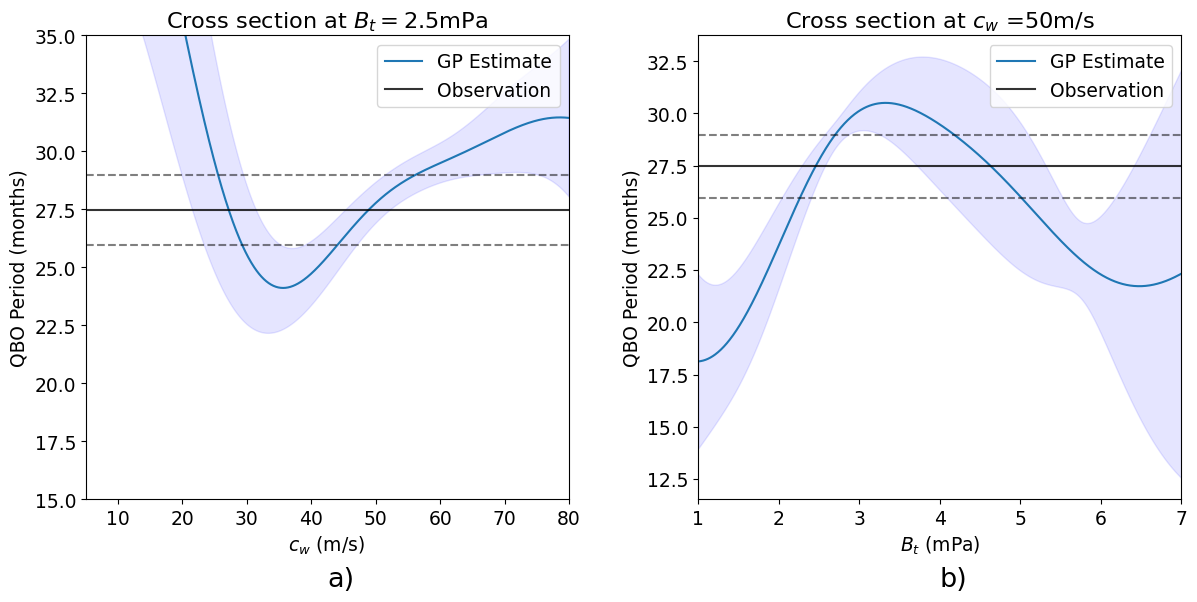

In [30]:
###SIDE BY SIDE USED IN MANUSCRIPT

fig,(axbt,axcw) = plt.subplots(nrows=1,ncols=2,figsize=(13,6.5))
fig.tight_layout(pad=4)
axcw.plot(Bt*1000,pred_period_cw,label='GP Estimate')
axcw.fill_between(Bt*1000, (pred_period_cw-pred_period_cw_std), (pred_period_cw+pred_period_cw_std), color='b', alpha=.1)
axcw.set_xlim([1,7])
axcw.axhline(period_ref-period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
axcw.axhline(period_ref,linestyle='-',color='black',alpha=0.8,label='Observation')
axcw.axhline(period_ref+period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
axcw.set_xlabel('$B_{t}$ (mPa)')
axcw.set_ylabel('QBO Period (months)')
axcw.legend()
axcw.set_title('Cross section at $c_w$ ='+str(CW_FIXED)+'m/s')
axcw.text(0.5, -0.2, "b)", transform=axcw.transAxes,
            fontsize='x-large', va='bottom', fontfamily='sans')
# ax2.plot(Bt,imp)
# ax2.fill_between(Bt,0,3,color='g',alpha=0.1,label='Satisfied 3 sigma rule')
# ax2.set_xlim([0.001,0.007])
# ax2.set_ylim([0,20])
# ax2.legend()
# ax2.set_ylabel("Implausibility")

axbt.plot(cw,pred_period_btw,label='GP Estimate')
axbt.fill_between(cw, (pred_period_btw-pred_period_btw_std), (pred_period_btw+pred_period_btw_std), color='b', alpha=.1)
axbt.set_xlim([5,80])
axbt.axhline(period_ref -period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
axbt.axhline(period_ref,linestyle='-',color='black',alpha=0.8,label='Observation')
axbt.axhline(period_ref+period_ref_err*1.96,linestyle='--',color='black',alpha=0.5)
axbt.set_xlabel("$c_w$ (m/s) ")
axbt.set_ylabel('QBO Period (months)')
axbt.legend()
axbt.set_ylim([15,35])
axbt.set_title('Cross section at $B_t ='+str(BT_FIXED*1000)+'$mPa')
axbt.text(0.5, -0.2, "a)", transform=axbt.transAxes,
            fontsize='x-large', va='bottom', fontfamily='sans')

plt.savefig(f'figures/wave_{ITERATION_NUMBER}_cross_section.png',dpi=300,bbox_inches='tight')

### Next wave change iteration plot
Plot the samples drawn from the current wave compared against the next wave as well as the next space subject to the implausibility significance level used. 


In [31]:
samples_next = pd.read_csv(os.path.join(DATADIR,f'{ITERATION_NUMBER+1}_samples.csv'),index_col='run_id')
space_next:SampleSpace = joblib.load(os.path.join(DATADIR,f'{ITERATION_NUMBER+1}.space'))

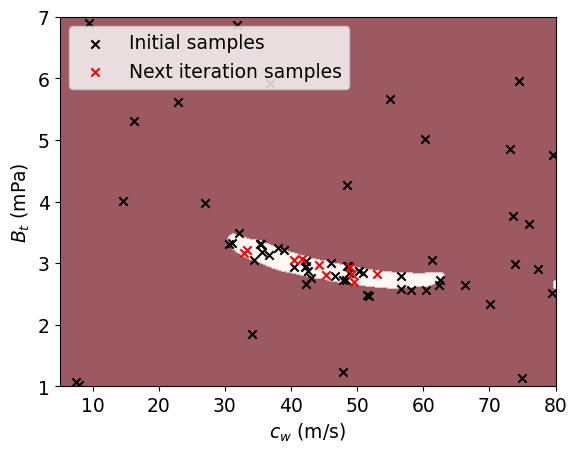

In [32]:
fig,ax = plt.subplots()
space_next.to_xarray().astype(int).interp(
    cwtropics=np.linspace(
        5,80,
        1000,
    ),
    Bt_eq=np.linspace(
        0.001,
        0.007,
        1000,
    ),
    kwargs={"fill_value": 0},
    ).astype(bool).plot.contourf(
        x="cwtropics",
        y="Bt_eq",
        ax=ax,
        alpha=0.65,
        cmap="Reds_r",
        levels=[0,0.9],
        add_colorbar=False,
        )
ax.scatter(samples['cwtropics'],samples['Bt_eq'],marker='x',label='Initial samples',color='black')
ax.scatter(samples_next['cwtropics'],samples_next['Bt_eq'],marker='x',color='red',label='Next iteration samples')
ax.legend()
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: int(x*1000)))
ax.set_ylabel('$B_t$ (mPa)')
ax.set_xlabel('$c_w$ (m/s)')
plt.savefig('figures/sample_50_comp.png',dpi=200)